TOC:
1. [x] Imports and import config
2. [x] Set device           
3. [x] Set Hyperparameters
4. [x] Load data
5. [x] Define Model
6. [x] Sanity check on model
7. [x] Initialize Model
8. [x] Define Loss and optimizer
9. [x] Training loop [training and validaion loop]
10. [x] Validation

# Imports and import config

In [1]:
!pip install -q timm

In [2]:
# Imports
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import Dataset, DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
from torchvision.transforms import Resize
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
import timm
import random

from albumentations.pytorch.transforms import ToTensorV2
import albumentations as A

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob
import time
import random

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

# For colored terminal text
from colorama import Fore, Back, Style
c_ = Fore.CYAN
sr_ = Style.RESET_ALL
b_ = Fore.BLUE

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Import Config & Set device    

In [3]:
# Import Config
pd.set_option('display.max_colwidth', None)
# torch.set_default_tensor_type('torch.cuda.FloatTensor')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# seeding for reproducibility
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

# Set Hyperparameters

In [4]:
# Hyperparameters
cfg = {
        "in_channels" :1,
        "num_classes": 19,
        "learning_rate" : 0.0001 * 8,
        "batch_size" : 32,
        "num_epochs" : 2,
        "n_accumulate": 1,
        "competition": "pogchamp2",
        "model_name": "resnet50",
        "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),

}
CONFIG = cfg

# Setup W&B

In [5]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")
    wandb.login(key=api_key)
    anonymous = None
except:
    anonymous = "must"
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')
# wandb.init(project="PogChamp2 Baseline")
run = wandb.init(project=CONFIG['competition'], 
                 config=CONFIG,
                 job_type='Train',
                 tags=['classification', "music", CONFIG['model_name'],'timm'],
                 anonymous='must',
                 name = "resnet50 timm classification",
                 notes = "")
       
# wandb.finish()

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: somusan (use `wandb login --relogin` to force relogin)


# Load data

In [6]:
## Reading spectograms and ignoring files not present

df_train = pd.read_csv('../input/kaggle-pog-series-s01e02/train.csv')
df_test = pd.read_csv('../input/kaggle-pog-series-s01e02/test.csv')

df_train['ID'] = df_train['filename'].str.split('.').str[0]
df_test['ID'] = df_test['filename'].str.split('.').str[0]

train_files = pd.DataFrame(glob.glob('../input/pogchamp2spectogram/kaggle/spectograms/train/*.jpg'), columns=['spec_path'])
test_files = pd.DataFrame(glob.glob('../input/pogchamp2spectogram/kaggle/spectograms/test/*.jpg'), columns=['spec_path'])

train_files['ID'] = train_files['spec_path'].str.split('/').str[-1].str.split('.').str[0]
test_files['ID'] = test_files['spec_path'].str.split('/').str[-1].str.split('.').str[0]

df_train_spec = pd.merge(df_train, train_files, how='right', on='ID')
df_test_spec = pd.merge(df_test, test_files, how='right', on='ID')

In [7]:
print("dataframe shape ", df_train_spec.shape)
df_train_spec.head()

dataframe shape  (19909, 7)


,song_id,filename,filepath,genre_id,genre,ID,spec_path
0,11035,011035.ogg,train/011035.ogg,1,Rock,011035,../input/pogchamp2spectogram/kaggle/spectograms/train/011035.jpg
1,304,000304.ogg,train/000304.ogg,1,Rock,000304,../input/pogchamp2spectogram/kaggle/spectograms/train/000304.jpg
2,12958,012958.ogg,train/012958.ogg,2,Punk,012958,../input/pogchamp2spectogram/kaggle/spectograms/train/012958.jpg
3,12248,012248.ogg,train/012248.ogg,0,Electronic,012248,../input/pogchamp2spectogram/kaggle/spectograms/train/012248.jpg
4,11502,011502.ogg,train/011502.ogg,1,Rock,011502,../input/pogchamp2spectogram/kaggle/spectograms/train/011502.jpg


In [8]:
excluded_files = ['003071.ogg', '003137.ogg', '004040.ogg', '009963.ogg',
       '011088.ogg', '013954.ogg', '015980.ogg', '016312.ogg',
       '017940.ogg', '022295.ogg', '022698.ogg', '023078.ogg',
       '024899.ogg', "010449.ogg" , "005589.ogg" , "004921.ogg", "019511.ogg" , "013375.ogg" , "024247.ogg", "024156.ogg"]

df = df_train_spec.copy()
length = len(df)
missing_file_index = []
data = {
    "song_id": [],
    "filename": [],
    "filepath": [],
    "genre_id": [],
    "ID": [],
    "spec_path": []
}

deleted_cnt = 0


for i in range(length):
    if df["filename"].iloc[i] in excluded_files:
        missing_file_index.append(i)
        temp = df["filename"].iloc[i]
        print(f"{c_}added index {temp}")
        deleted_cnt+=1
    else:
        data["song_id"].append(df["song_id"].iloc[i])
        data["filename"].append(df["filename"].iloc[i])
        data["filepath"].append(df["filepath"].iloc[i])
        data["genre_id"].append(df["genre_id"].iloc[i])
        data["ID"].append(df["ID"].iloc[i])
        data["spec_path"].append(df["spec_path"].iloc[i])
#         temp = df["filename"].iloc[i]
#         print(f"{b_} added --> {temp}")

print("total deleted file count: ", deleted_cnt)

added index 024156.ogg
added index 013375.ogg
added index 019511.ogg
added index 024247.ogg
added index 005589.ogg
added index 010449.ogg
added index 004921.ogg
total deleted file count:  7


In [9]:
pure_df = pd.DataFrame(data)
print("shape", pure_df.shape)
pure_df.head()

shape (19902, 6)


,song_id,filename,filepath,genre_id,ID,spec_path
0,11035,011035.ogg,train/011035.ogg,1,011035,../input/pogchamp2spectogram/kaggle/spectograms/train/011035.jpg
1,304,000304.ogg,train/000304.ogg,1,000304,../input/pogchamp2spectogram/kaggle/spectograms/train/000304.jpg
2,12958,012958.ogg,train/012958.ogg,2,012958,../input/pogchamp2spectogram/kaggle/spectograms/train/012958.jpg
3,12248,012248.ogg,train/012248.ogg,0,012248,../input/pogchamp2spectogram/kaggle/spectograms/train/012248.jpg
4,11502,011502.ogg,train/011502.ogg,1,011502,../input/pogchamp2spectogram/kaggle/spectograms/train/011502.jpg


In [10]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(pure_df, test_size=0.2, random_state = 42)

In [11]:
train_df.shape, valid_df.shape

((15921, 6), (3981, 6))

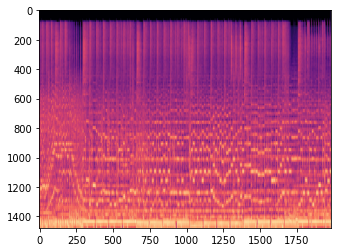

In [12]:
demo = plt.imread("../input/pogchamp2spectogram/kaggle/spectograms/train/000304.jpg")
# print(demo)
plt.imshow(demo)

In [13]:
# class POGdata(Dataset):
#     def __init__(self, df, transforms=None):
#         super().__init__()
#         self.df = df
#         self.transforms = transforms

#     def __getitem__(self, index):
#         path = self.df["spec_path"].iloc[index]
#         image = plt.imread(path)

#         target = self.df["genre_id"].iloc[index]
        
#         if self.transforms:
#             image = self.transforms(image=image)['image']
            
#         return image.float(), torch.tensor(target, dtype=torch.long)

#     def __len__(self):
#         return len(self.df)

In [14]:
import torchaudio

class POGdata(Dataset):
    
    def __init__(self,
                 df,
                 data_dir,
                 transform = None):
        super(POGdata, self).__init__()
        self.data_dir = data_dir
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):

        path = self.df["filename"].iloc[index]
        path = os.path.join(self.data_dir, path)

        label = self.df["genre_id"].iloc[index]
        mono_audio = self.load_audio(path)
        mono_audio = mono_audio.unsqueeze(dim=0)
        return mono_audio, label
    
    
    def load_audio(self, path):
        audio, _ = torchaudio.load(path)
        if self.transform != None:
            for aug in self.transform:
                audio = aug(audio)
        return audio[0,:]

In [15]:
SAMPLE_RATE = 22050
NUM_SAMPLES = 22050
N_FFT = 2048
HOP_LEN = 512

augm = [
    MelSpectrogram(sample_rate=SAMPLE_RATE,
                    n_fft=1024,
                    hop_length=512,
                    n_mels=256),
    AmplitudeToDB(),
    Resize((256, 256))
]
augm

/opt/conda/lib/python3.7/site-packages/torchaudio/functional/functional.py:433: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


[MelSpectrogram(
   (spectrogram): Spectrogram()
   (mel_scale): MelScale()
 ),
 AmplitudeToDB(),
 Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)]

In [16]:
# metadata_path = "./training_metadata.csv"
dataset = POGdata(train_df, "../input/kaggle-pog-series-s01e02/train", transform = augm)

In [17]:
data, label = dataset[10]
print("Audio Shape : {} , label : {}".format(data.shape, label))

Audio Shape : torch.Size([1, 256, 256]) , label : 0


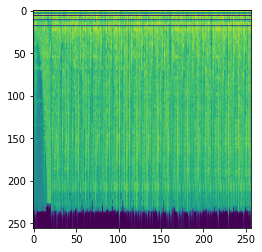

In [18]:
plt.imshow(data.permute(1,2,0).numpy())

In [19]:
train_ds = POGdata(train_df, "../input/kaggle-pog-series-s01e02/train", transform = augm)
valid_ds = POGdata(valid_df, "../input/kaggle-pog-series-s01e02/train", transform = augm)

train_dl = DataLoader(train_ds, batch_size=cfg["batch_size"], shuffle=False,pin_memory = True, num_workers  = 2)
valid_dl = DataLoader(valid_ds, batch_size=cfg["batch_size"], shuffle=False,pin_memory = True, num_workers  = 2)

In [20]:
"""
pin_memory = False  ---|___> 32 min/epoch
num_workers = 4     ---|   

pin_memory = True  ---|___> 27 min/epoch
num_workers = 2     ---|   

pin_memory = False  ---|___> 26 min/epoch
num_workers = 2     ---|   
"""

'\npin_memory = False  ---|___> 32 min/epoch\nnum_workers = 4     ---|   \n\npin_memory = True  ---|___> 27 min/epoch\nnum_workers = 2     ---|   \n\npin_memory = False  ---|___> 26 min/epoch\nnum_workers = 2     ---|   \n'

In [21]:
# transform_train = A.Compose([
#                   A.Resize(256, 256, p=1),                
#                   ToTensorV2(),
# ])
# transform_valid = A.Compose([
#                   A.Resize(256, 256, p=1),
#                   ToTensorV2(),
# ])


# train_data = POGdata(train_df,transform_train)
# img, trg = train_data[20]
# print(img.shape)
# plt.imshow(img.permute(1,2,0).numpy())

In [22]:
# img.max()

In [23]:
# train_ds = POGdata(train_df,transform_train)
# valid_ds = POGdata(valid_df,transform_valid)

# train_dl = DataLoader(train_ds, batch_size=cfg["batch_size"], shuffle=False,pin_memory=True,num_workers  = 4)
# valid_dl = DataLoader(valid_ds, batch_size=cfg["batch_size"], shuffle=False,pin_memory=True,num_workers  = 4)

# Define Model

In [24]:
# use timm model no pretrained
class BaseModel(nn.Module):
    def __init__(self, model_name="resnet50", n_class=19, pretrained=False):
        super().__init__()
        
        self.model = timm.create_model(model_name, in_chans=1, pretrained=pretrained, num_classes = 19)
        n_features = self.model.fc.in_features
        self.model.classifier = nn.Linear(n_features, n_class) 
    def forward(self, x):
        output = self.model(x)
        return output

In [25]:

# # Define Model [Here CNN]
# class CNN(nn.Module):
#     def __init__(self, in_channels=1, num_classes=10):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(        # i/p size = 1x28x28, o/p size = 8x28x28 [coz = [(28+2*1-3)/1] + 1 = 28] Formula: https://i.imgur.com/Nh2cRt9.png
#             in_channels=in_channels,   # this is the num of channel present in the single image, for RGB=3, gray scale= 1
#             out_channels=8,            # you can mention any output channel, eg: 8, 16, 70 etc ...
#             kernel_size=(3, 3),
#             stride=(1, 1),
#             padding=(1, 1),
#         )
#         self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))  # i/p size = 8x28x28, o/p size = 8x14x14 [coz = [(28+2*0-2)/2] + 1 = 14]
#         self.conv2 = nn.Conv2d(                                      
#             in_channels=8,                                           # i/p size = 8x14x14, o/p size = 16x14x14 [coz = [(14+2*1-3)/1] + 1 = 14]
#             out_channels=16,
#             kernel_size=(3, 3),
#             stride=(1, 1),
#             padding=(1, 1),
#         )
#         self.fc1 = nn.Linear( 65536, num_classes)     # i/p size = 16x7x7 [coz we will apply self.pool two time, after self.conv2] , 
#                                                           # o/p size = 10 

#     def forward(self, x):
#         x = F.relu(self.conv1(x))                    # we are applying relu here
#         x = self.pool(x)
#         x = F.relu(self.conv2(x))
#         x = self.pool(x)
#         x = x.reshape(x.shape[0], -1)                # before passing the data to the linear layer we need to flatten the data 
#                                                      # x.shape[0] will secure the batch size and -1 used for flattening rest of the 
#         x = self.fc1(x)
#         return x


# Sanity check on model

- Sanity check w/ forward pass to check GPU utilization.

<br>
<img width = "500" src="https://i.imgur.com/j9nNG4m.jpg">

In [26]:
# Sanity check on model
Model = BaseModel()
print(Model(torch.randn(64,1,256,256)).shape) # O/p -> (64,19) 64=batch size, 19= num of class

torch.Size([64, 19])


# Initialize Model

In [27]:
# Initialize network
model = BaseModel().to(device)

# Define Loss and optimizer

In [28]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()   # reminder: every loss accepts different predictin and target shape, eg: BCEw/logits uses different shapes for them
optimizer = optim.Adam(model.parameters(), lr=cfg["learning_rate"])

In [29]:
def save_model(epoch, model, model_file):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, model_file)

# Training loop [training and validaion loop]

In [30]:
# # Train Network
# total_epoch = cfg["num_epochs"]
# for epoch in range(cfg["num_epochs"]):
#     print(f"============ starting epoch [{epoch+1}/{total_epoch}] ============")
#     running_loss = 0.0
    
    
#     for i, (data, targets) in enumerate(tqdm(train_dl)):
#         # Get data to cuda if possible
#         data = data.to(device=device)
#         targets = targets.to(device=device)
        
#         # forward
#         scores = model(data)
#         loss = criterion(scores, targets)  # CrossEntropyLoss accepts prediction in the shape of (64,10) and target is 64 [not sure]

#         # backward
#         optimizer.zero_grad()
#         loss.backward()

#         # gradient descent or adam step
#         optimizer.step()
        
#         running_loss += loss.item()

#         if i % 4 == 0:    # print every 4 mini-batches
# #             print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
#             wandb.log({'epoch': epoch+1, 'loss': running_loss/2000})
#             running_loss = 0.0
        
#     print(f"total loss {running_loss}")
# #     print('Finished Training')
    
#     save_model(epoch,model,f"cnn_adam_e{epoch}.pth")

In [31]:
# iyyiiv sdgsdg fdgdf fghgh badass

In [32]:
# https://www.kaggle.com/code/debarshichanda/pytorch-w-b-birdclef-22-starter
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (data, targets) in bar:
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        batch_size = data.size(0)
        
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss = loss / cfg['n_accumulate']
            
        loss.backward()
    
        if (step + 1) % cfg['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
#         running_loss += (loss.item() * batch_size)
        running_loss += loss.item()
#         epoch_loss = running_loss / dataset_size
        dataset_size += batch_size
        
        epoch_loss = running_loss / len(dataloader)
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [33]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    LABELS = []
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (data, targets) in bar:
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        batch_size = data.size(0)

        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, targets)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        PREDS.append(preds.view(-1).cpu().detach().numpy())
        LABELS.append(targets.view(-1).cpu().detach().numpy())
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])   
    
    LABELS = np.concatenate(LABELS)
    PREDS = np.concatenate(PREDS)
    val_f1 = f1_score(LABELS, PREDS, average='macro')
    gc.collect()
    
    return epoch_loss, val_f1

In [34]:
# https://www.kaggle.com/code/debarshichanda/pytorch-w-b-birdclef-22-starter
def run_training(model, train_loader, valid_loader, optimizer, device, num_epochs, scheduler=None):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_f1 = 0
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=cfg['device'], epoch=epoch)
        
        val_epoch_loss, val_epoch_f1 = valid_one_epoch(model, valid_loader, 
                                                       device=cfg['device'], 
                                                       epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Valid F1'].append(val_epoch_f1)
        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Valid F1": val_epoch_f1})
        
        # deep copy the model
        if val_epoch_f1 >= best_epoch_f1:
            print(f"{b_}Validation F1 Improved ({best_epoch_f1} ---> {val_epoch_f1})")
            best_epoch_f1 = val_epoch_f1
            run.summary["Best F1 Score"] = best_epoch_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "F1{:.4f}_epoch{:.0f}.bin".format(best_epoch_f1, epoch)
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best F1: {:.4f}".format(best_epoch_f1))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [35]:
run = wandb.init(project=cfg['competition'], 
                 config=cfg,
                 job_type='Train',
                 tags=['baseline', cfg['model_name']],
                 anonymous='must')

<!-- # TODOs:
- change loss updation loss.item() * batch size to loss.item()
- Use bigger model
- save raw spec images on disk and then load from there -->

```
Pin_memory=False
100%|██████████| 498/498 [32:06<00:00,  3.87s/it, Epoch=1, LR=0.0008, Train_Loss=1.96]  
100%|██████████| 125/125 [08:31<00:00,  4.09s/it, Epoch=1, LR=0.0008, Valid_Loss=1.88
```

In [36]:
import copy
from collections import defaultdict
import gc

model, history = run_training(model,train_dl,
                              valid_dl, optimizer,
                              device=cfg['device'],
                              num_epochs=cfg['num_epochs'])

[INFO] Using GPU: Tesla P100-PCIE-16GB



100%|██████████| 125/125 [08:33<00:00,  4.11s/it, Epoch=1, LR=0.0008, Valid_Loss=1.9]


Validation F1 Improved (0 ---> 0.2361178186691721)
Model Saved



100%|██████████| 125/125 [08:35<00:00,  4.12s/it, Epoch=2, LR=0.0008, Valid_Loss=1.96]


Validation F1 Improved (0.2361178186691721 ---> 0.25154931053318175)
Model Saved

Training complete in 1h 21m 44s
Best F1: 0.2515


# validation

<!-- ,　　　
.　　　　　　　　　　　　　.　　　ﾟ　 　　　.　　　　　　　　 🌑　　　　　 　　　　　.　　　　　　　　　　　.　　　　　　　　　　 　
　˚　　　　　　　　　　　　　　　　　　　　　ﾟ　　　　　.　　　　　　　　　　　　　　　. 　　 　 🌎 ‍ ‍ ‍ ‍ ‍ ‍ ‍ ‍ ‍ ‍ ,　 　　　　　　　　　　　　　　* .　　　　　 　　　　　　　　　　　　　　.　　　　　　　　　　 ✦ 　　　　 　 　　　˚　　　　　　　　　　　　　　*　　　　　　 　　　　　　　　　　　　　　　.　　
.　　　　　　　　　　　　　.　　　ﾟ　 　　　.　　　　　　　　　　　　　.
　　　　　　,　　　　　　　.　　　　　　 　　　　 　　　　　　　　　　　　　　　　　　 ☀️　　　　　　　　　　　　　　　　　　 　 　　　　　 　　　　*　　　　　　　　　.　　　　　　　　　　.　　　　　　　　　　　　　. 　　　　　　　　　　　　　　　　 　 　　　　 　　　　　　　　　　　　　　　　 　 　　　　　　　　　　　　　　　　 　 ✦ 　 　　　,　　　　　　　　　*　　 🚀 　　　　 　　,　　　 ‍ ‍ ‍ ‍　 　　　　　　　　　　　　.　　　　　 　　 　　　.　　　　　　　　　　　　　 　 　　　　　　　　　　　　　　　　　　　˚　　　 　 　　　　,　　　　　　　　　　　 　 　　　　　　　　　　　　　　　　.　　　 　　 　　　　　 　　　　
　　　　　　　　　
　　　　　　　　　　　　　* 　　 　　　　　 ✦ 　　　　　　　 　 　　　　 　　 　　　　　　　 　　　　　.　　　　　　　　　　　　　　　　　　.　　　　　 　　. 　 　　　　　.　　　　 🌑　　　　　 　　　　　.                                                   .

 -->

In [37]:
# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)


    model.train()
    return num_correct/num_samples


print(f"Accuracy on training set: {check_accuracy(train_dl, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(valid_dl, model)*100:.2f}")

Accuracy on training set: 36.96
Accuracy on test set: 35.97
